In [1]:
import os
import re
import json
import gc
import time

#root dirqps
os.chdir("/home/tiagoalmeida/bioASQ-taskb/")
from pubmed_data import pubmed_helper as ph

from models.fast_neural_retrieval.bm25_model import BM25
from models.fast_neural_retrieval.elasticsearch_bm25_model import BM25_ES
from models.deep_model_for_ir.deeprank_v2_model import DeepRankV2
from models.deep_model_for_ir.deeprank_v4_model import DeepRankV4
from models.deep_model_for_ir.deeprank_v6_model import DeepRankV6
from models.deep_model_for_ir.har_model import HAR
#import models.deep_model_for_ir.deeprank_v2_model

import


In [2]:
#Load BM25
#bm25 = BM25.load(full_tokens=True)
bm25 = BM25_ES()

#Load deeprank
#deeprank = DeepRankV6.load()

Load bllip_stem_full_tokens_tokenizer.p


In [8]:
#load articles
articles = []
for article in ph.create_pubmed_collection_generator()():
    articles.extend(map(lambda x:x["title"]+" "+x["abstract"],article))

Open /backup/pubmed_archive_json/pubmed_ready.tar.gz
Creating generator
Open the file: pubmed_ready_00000000_to_02776362
Returning: 2776363 articles
Force garbage collector 157
Open the file: pubmed_ready_02776363_to_05519968
Returning: 2743606 articles
Force garbage collector 0
Open the file: pubmed_ready_05519969_to_08241071
Returning: 2721103 articles
Force garbage collector 0
Open the file: pubmed_ready_08241072_to_11124313
Returning: 2883242 articles
Force garbage collector 0
Open the file: pubmed_ready_11124314_to_13996815
Returning: 2872502 articles
Force garbage collector 0
Open the file: pubmed_ready_13996816_to_18824354
Returning: 4827539 articles
Force garbage collector 0


In [3]:
###TEST on Validation DATA!

bioASQ_data_path = "/backup/BioASQ-training7b/"
bioASQ_data_test = json.load(open(os.path.join(bioASQ_data_path,"7b_test_split.json")))

s_t = time.time()

bm25.predict(bioASQ_data_test[-100:], top_k=2500)

print("bm25 ftime", time.time() - s_t)
#load pmid_index mapping
#pmid_index_mapping = ph.pmid_index_mapping()
#index_to_pmid = lambda x:pmid_index_mapping.inverse[x]
#BATCH_SIZE = 100
#bioASQ_bm25_result={}
#for i in range(0, len(bioASQ_data_test), BATCH_SIZE):
#    bioASQ_bm25_result.update(bm25.predict(bioASQ_data_test[i:i+BATCH_SIZE], use_precomputed_score = True, top_k=2500))



#bioASQ_bm25_result = bm25.predict(bioASQ_data_test, top_k=2500)
    
#for query_fast_r in bioASQ_bm25_result.values():
#        query_fast_r["documents"] = list(map(lambda x:(pmid_index_mapping[x[0]],x[1])
#                                             ,query_fast_r["documents"]))

 
    
#bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)



BM25 ES time 13.206984758377075
BM25 ES time 12.827526092529297
BM25 ES time 12.201692581176758
BM25 ES time 11.23131275177002
BM25 ES time 12.607797145843506
BM25 ES time 12.256036281585693
BM25 ES time 12.392575740814209
BM25 ES time 12.218801021575928
BM25 ES time 12.839336395263672
BM25 ES time 11.857046127319336
BM25 ES time 11.650475263595581
BM25 ES time 12.49608826637268
BM25 ES time 13.18127727508545
BM25 ES time 10.962259769439697
BM25 ES time 11.302042961120605
BM25 ES time 12.938149690628052
BM25 ES time 13.546004295349121
BM25 ES time 12.361980438232422
BM25 ES time 11.540140628814697
BM25 ES time 11.156026363372803
BM25 ES time 12.275221824645996
BM25 ES time 13.767176389694214
BM25 ES time 12.447558641433716
BM25 ES time 12.313791751861572
BM25 ES time 10.796972036361694
BM25 ES time 12.387305736541748
BM25 ES time 10.662259340286255
BM25 ES time 11.550838947296143
BM25 ES time 0.16987371444702148
BM25 ES time 11.463444709777832
BM25 ES time 11.83539628982544
BM25 ES tim

In [9]:
bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)

Start DR predict
Prediction avg time 10.32582017936776 Sort avg time 0.001571240538022123


In [10]:
from models.generic_model import f_recall, __precision


from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline


def f_precision(predictions,expectations,at=2500):
    """
    predictions: list of list of pmid
    expectations: list of list of pmid
    """
    
    assert len(predictions) == len(expectations)
    
    return sum([ __precision(predictions[i][:at],expectations[i]) for i in range(len(predictions))])/len(predictions)



index_to_pmid = lambda x : pmid_index_mapping.inverse[x]

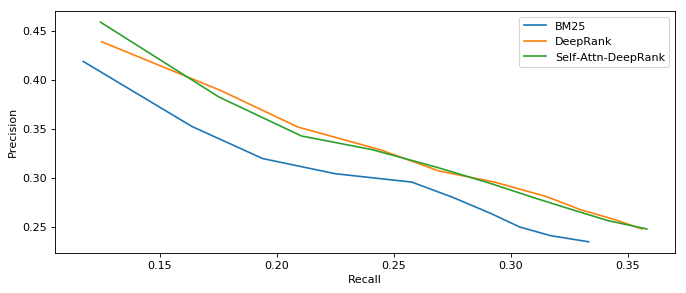

In [20]:
#deep_rank_v2_result_dict = {q["id"]:q["documents"] for q in bioASQ_deeprank_result}

#deep_rank_v6_result_dict = {q["id"]:q["documents"] for q in bioASQ_deeprank_result}
#precision-recall curve for bm25
deep_rank_v2_predicts = []
deep_rank_v6_predicts = []
bm25_predicts = []
true = []

for query_data in bioASQ_data_test:
    bm25_predicts.append(list(map(lambda x: index_to_pmid(x[0]), bioASQ_bm25_result[query_data["id"]]["documents"][:10])))
    deep_rank_v2_predicts.append(deep_rank_v2_result_dict[query_data["id"]][:10])
    deep_rank_v6_predicts.append(list(map(lambda x: x.split("/")[-1], deep_rank_v6_result_dict[query_data["id"]][:10])))
    true.append(query_data["documents"])

at_pr_curves = list(range(1,11)) #(list(range(1,2500))+ [2500])
precision_bm25_list = []
recall_bm25_list = []

precision_dpv2_list = []
recall_dpv2_list = []

precision_dpv6_list = []
recall_dpv6_list = []

for i in at_pr_curves:
    print(i,end="\r")
    precision_bm25_list.append(f_precision(bm25_predicts,true,at=i))
    recall_bm25_list.append(f_recall(bm25_predicts,true,at=i))
    
    precision_dpv2_list.append(f_precision(deep_rank_v2_predicts,true,at=i))
    recall_dpv2_list.append(f_recall(deep_rank_v2_predicts,true,at=i))
    
    precision_dpv6_list.append(f_precision(deep_rank_v6_predicts,true,at=i))
    recall_dpv6_list.append(f_recall(deep_rank_v6_predicts,true,at=i))



figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(recall_bm25_list, precision_bm25_list, '-')
plt.plot(recall_dpv2_list,precision_dpv2_list,  '-')
plt.plot(recall_dpv6_list,precision_dpv6_list,  '-')

plt.legend(["BM25","DeepRank","Self-Attn-DeepRank"])

#plt.title("Behavior of both DeepRank variations for different ranks of MAP@")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()    


In [21]:

def interpolated_precision(recall_list,precision_list):
    recall_levels = [ x/10 for x in range(0,11) ]
    precision_interpolated = []
    for e,i in enumerate(recall_levels):
        #search recall
        for j,k in enumerate(recall_list):

            if k>=i:
                #max precision
                precision_interpolated.append(max(precision_list[j:]))
                break
        
        if len(precision_interpolated)==e:
            precision_interpolated.append(precision_interpolated[-1])
        
    return precision_interpolated


##Compute precision-recall curvers interpolated
recall_levels = [ x/10 for x in range(0,11) ]
precision_bm25_interpolated = interpolated_precision(recall_bm25_list,precision_bm25_list)
precision_dpv2_interpolated = interpolated_precision(recall_dpv2_list,precision_dpv2_list)
precision_dpv6_interpolated = interpolated_precision(recall_dpv6_list,precision_dpv6_list)


            




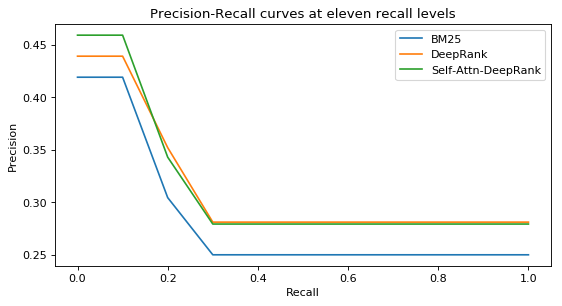

In [22]:
figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(recall_levels, precision_bm25_interpolated, '-')
plt.plot(recall_levels, precision_dpv2_interpolated,  '-')
plt.plot(recall_levels, precision_dpv6_interpolated,  '-')

plt.legend(["BM25","DeepRank","Self-Attn-DeepRank"])

plt.title("Precision-Recall curves at eleven recall levels")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()

In [37]:
with open("deep_rank_v2_validation_set_result.json","w") as f:
    json.dump(bioASQ_deeprank_result,f)

for x in bioASQ_deeprank_result:
    x["documents"] = list(map(lambda y:"http://www.ncbi.nlm.nih.gov/pubmed/"+y,x["documents"]))
    
with open("deep_rank_v2_validation_set_result_bioasq.json","w") as f:
    json.dump(bioASQ_deeprank_result,f)



In [39]:
del deeprank
gc.collect()

har = HAR.load()

bioASQ_har_result = har.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)

with open("har_validation_set_result.json","w") as f:
    json.dump(bioASQ_har_result,f)

for x in bioASQ_har_result:
    x["documents"] = list(map(lambda y:"http://www.ncbi.nlm.nih.gov/pubmed/"+y,x["documents"]))
    
with open("har_validation_set_result_bioasq.json","w") as f:
    json.dump(bioASQ_har_result,f)

Load regex_full_tokens_tokenizer.p
Build Model
x_projection Tensor("self_attention/Reshape_2:0", shape=(?, 13, 100), dtype=float32)
x_tanh Tensor("self_attention/Tanh:0", shape=(?, 13, 100), dtype=float32)
x_attention Tensor("self_attention/Reshape_5:0", shape=(?, 13, 1), dtype=float32)
x_attention_softmax Tensor("self_attention/transpose_3:0", shape=(?, 13, 1), dtype=float32)
x_scored_emb Tensor("self_attention/mul:0", shape=(?, 13, 100), dtype=float32)
x_attention_rep Tensor("self_attention/Sum:0", shape=(?, 100), dtype=float32)
query_len 13
doc_len 13
doc_embedding (?, 13, 100)
query_embedding (?, 13, 100)
doc_q_matrix (?, 13, 1, 100)
doc_q_matrix (?, 13, 13, 100)
q_doc_matrix (?, 1, 13, 100)
q_doc_matrix (?, 13, 13, 100)
element_mult (?, 13, 13, 100)
S (?, 13, 13, 300)
Wc (300, 1)
S (?, 13, 13, 1)
S (?, 13, 13)
S_D2Q (?, 13, 13)
S_Q2D (?, 13, 13)
A_D2Q (?, 13, 100)
S_Q2D_transpose (?, 13, 13)
A_D2Q_Q2D (?, 13, 13)
A_Q2D (?, 13, 100)
doc_attn (?, 13, 100)
doc_q_attn (?, 13, 100)
x_p

doc_embedding (?, 13, 100)
query_embedding (?, 13, 100)
doc_q_matrix (?, 13, 1, 100)
doc_q_matrix (?, 13, 13, 100)
q_doc_matrix (?, 1, 13, 100)
q_doc_matrix (?, 13, 13, 100)
element_mult (?, 13, 13, 100)
S (?, 13, 13, 300)
Wc (300, 1)
S (?, 13, 13, 1)
S (?, 13, 13)
S_D2Q (?, 13, 13)
S_Q2D (?, 13, 13)
A_D2Q (?, 13, 100)
S_Q2D_transpose (?, 13, 13)
A_D2Q_Q2D (?, 13, 13)
A_Q2D (?, 13, 100)
doc_attn (?, 13, 100)
doc_q_attn (?, 13, 100)
x_projection Tensor("self_attention_1_9/Reshape_2:0", shape=(?, 13, 100), dtype=float32)
x_tanh Tensor("self_attention_1_9/Tanh:0", shape=(?, 13, 100), dtype=float32)
x_attention Tensor("self_attention_1_9/Reshape_5:0", shape=(?, 13, 1), dtype=float32)
x_attention_softmax Tensor("self_attention_1_9/transpose_3:0", shape=(?, 13, 1), dtype=float32)
x_scored_emb Tensor("self_attention_1_9/mul:0", shape=(?, 13, 400), dtype=float32)
x_attention_rep Tensor("self_attention_1_9/Sum:0", shape=(?, 400), dtype=float32)
doc_embedding (?, 13, 100)
query_embedding (?, 13,

doc_embedding (?, 13, 100)
query_embedding (?, 13, 100)
doc_q_matrix (?, 13, 1, 100)
doc_q_matrix (?, 13, 13, 100)
q_doc_matrix (?, 1, 13, 100)
q_doc_matrix (?, 13, 13, 100)
element_mult (?, 13, 13, 100)
S (?, 13, 13, 300)
Wc (300, 1)
S (?, 13, 13, 1)
S (?, 13, 13)
S_D2Q (?, 13, 13)
S_Q2D (?, 13, 13)
A_D2Q (?, 13, 100)
S_Q2D_transpose (?, 13, 13)
A_D2Q_Q2D (?, 13, 13)
A_Q2D (?, 13, 100)
doc_attn (?, 13, 100)
doc_q_attn (?, 13, 100)
x_projection Tensor("self_attention_1_18/Reshape_2:0", shape=(?, 13, 100), dtype=float32)
x_tanh Tensor("self_attention_1_18/Tanh:0", shape=(?, 13, 100), dtype=float32)
x_attention Tensor("self_attention_1_18/Reshape_5:0", shape=(?, 13, 1), dtype=float32)
x_attention_softmax Tensor("self_attention_1_18/transpose_3:0", shape=(?, 13, 1), dtype=float32)
x_scored_emb Tensor("self_attention_1_18/mul:0", shape=(?, 13, 400), dtype=float32)
x_attention_rep Tensor("self_attention_1_18/Sum:0", shape=(?, 400), dtype=float32)
doc_embedding (?, 13, 100)
query_embedding (

Start DR predict
Prediction avg time 4.916166288170875 Sort avg time 0.0015839375216235663


In [40]:
del har
gc.collect()

deeprankV6 = DeepRankV6.load()

bioASQ_deeprankV6_result = deeprankV6.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)

with open("deeprank_v6_validation_set_result.json","w") as f:
    json.dump(bioASQ_deeprankV6_result,f)

for x in bioASQ_deeprankV6_result:
    x["documents"] = list(map(lambda y:"http://www.ncbi.nlm.nih.gov/pubmed/"+y,x["documents"]))
    
with open("deeprank_v6_validation_set_result_bioasq.json","w") as f:
    json.dump(bioASQ_deeprankV6_result,f)

Load regex_full_tokens_tokenizer.p
Build Model


	Input Layer Model




snippet_emb_model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
snippet_token (InputLayer)   (None, 13, 5, 15)         0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 13, 5, 15, 200)    858359000 
_________________________________________________________________
snippet_transpose (Lambda)   (None, 13, 5, 200, 15)    0         
Total params: 858,359,000
Trainable params: 0
Non-trainable params: 858,359,000
_________________________________________________________________


	Measure Model


Tensor("masked_conv2d/sub:0", shape=(), dtype=float32)


cnn_extraction_model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d (MaskedConv2D) (None, 11, 13, 100)       10

x_attention_softmax Tensor("masked_self_attention_7/transpose_3:0", shape=(?, 5, 1), dtype=float32)
x_scored_emb Tensor("masked_self_attention_7/mul_1:0", shape=(?, 5, 101), dtype=float32)
x_attention_rep Tensor("masked_self_attention_7/Sum:0", shape=(?, 101), dtype=float32)
Tensor("TD_cnn_extraction_model_8/time_distributed/masked_conv2d/sub:0", shape=(), dtype=float32)
condition Tensor("masked_self_attention_8/All:0", shape=(?, 5, 1), dtype=bool)
inv_condition Tensor("masked_self_attention_8/sub:0", shape=(?, 5, 1), dtype=float32)
x_projection Tensor("masked_self_attention_8/Reshape_2:0", shape=(?, 5, 101), dtype=float32)
x_tanh Tensor("masked_self_attention_8/Tanh:0", shape=(?, 5, 101), dtype=float32)
x_attention Tensor("masked_self_attention_8/Reshape_5:0", shape=(?, 5, 1), dtype=float32)
x_attention_maked Tensor("masked_self_attention_8/add:0", shape=(?, 5, 1), dtype=float32)
x_attention_softmax Tensor("masked_self_attention_8/transpose_3:0", shape=(?, 5, 1), dtype=float32)
x_scor

Start DR predict
Prediction avg time 10.475920226838854 Sort avg time 0.0015786245655275216


In [44]:
##small correction
with open("har_validation_set_result_bioasq.json","r") as f:
    bioASQ_har_result = json.load(f)

for x in bioASQ_har_result:
    x["documents"] = list(map(lambda y:"http://www.ncbi.nlm.nih.gov/pubmed/"+y.split("/")[-1],x["documents"]))
    
with open("har_validation_set_result_bioasq.json","w") as f:
    json.dump(bioASQ_har_result,f)
    
    
with open("deeprank_v6_validation_set_result_bioasq.json","r") as f:
    bioASQ_deeprankV6_result = json.load(f)

for x in bioASQ_deeprankV6_result:
    x["documents"] = list(map(lambda y:"http://www.ncbi.nlm.nih.gov/pubmed/"+y.split("/")[-1],x["documents"]))

with open("deeprank_v6_validation_set_result_bioasq.json","w") as f:
    json.dump(bioASQ_deeprankV6_result,f)

In [89]:
#bm25 baseline
deepv6_results = []
deepv2_results = []
bm25_results = []
bioASQ_expectation = []

#back to dict
bioASQ_deeprankV6_result_dict = {x["id"]:list(map(lambda y:y.split("/")[-1],x["documents"])) for x in bioASQ_deeprankV6_result}
bioASQ_deeprankV2_result_dict = {x["id"]:list(map(lambda y:y.split("/")[-1],x["documents"])) for x in bioASQ_deeprank_result}

for query in bioASQ_data_test:
    bioASQ_expectation.append(query["documents"])
    deepv6_results.append(bioASQ_deeprankV6_result_dict[query["id"]])
    deepv2_results.append(bioASQ_deeprankV2_result_dict[query["id"]])
    bm25_results.append(list(map(lambda y:index_to_pmid(y[0]),bioASQ_bm25_result[query["id"]]["documents"])))



In [113]:
print(f_map(predictions=bm25_results,expectations=bioASQ_expectation,use_len=True))
print(f_map(predictions=deepv6_results, expectations=bioASQ_expectation,use_len=True))
print(f_map(predictions=deepv2_results, expectations=bioASQ_expectation,use_len=True))

recall_at = [x for x in range(5,101)]#[10,,50,100]
bm25_y_points = []
v2_y_points = []
v6_y_points = []


for at in recall_at:
    print("RECALL AT:",at)
    bm25_recall = f_map(predictions=bm25_results,expectations=bioASQ_expectation,at=at,bioASQ=True)
    print("bm25:",bm25_recall)
    v2_recall = f_map(predictions=deepv2_results, expectations=bioASQ_expectation,at=at,bioASQ=True)
    print("deeprankV2:",v2_recall,int((v2_recall-bm25_recall)/bm25_recall*100))
    v6_recall = f_map(predictions=deepv6_results, expectations=bioASQ_expectation,at=at,bioASQ=True)
    print("deeprankV6:",v6_recall,int((v6_recall-bm25_recall)/bm25_recall*100))
    bm25_y_points.append(bm25_recall)
    v2_y_points.append(v2_recall)
    v6_y_points.append(v6_recall)


0.23317999718156862
0.25287009972835767
0.2536610569659617
RECALL AT: 5
bm25: 0.10923800850030356
deeprankV2: 0.11906800242865817 8
deeprankV6: 0.12038554948391023 10
RECALL AT: 6
bm25: 0.11986338797814208
deeprankV2: 0.13212204007286 10
deeprankV6: 0.13152701882210094 9
RECALL AT: 7
bm25: 0.12860655737704915
deeprankV2: 0.14224434035909447 10
deeprankV6: 0.14141512707086484 9
RECALL AT: 8
bm25: 0.13766848816029145
deeprankV2: 0.15128350247202704 9
deeprankV6: 0.15125119264463527 9
RECALL AT: 9
bm25: 0.14620926937866818
deeprankV2: 0.1601278659611993 9
deeprankV6: 0.15991340677133023 9
RECALL AT: 10
bm25: 0.15353167375025284
deeprankV2: 0.16826994246393154 9
deeprankV6: 0.16800083846531935 9
RECALL AT: 11
bm25: 0.1593770123824767
deeprankV2: 0.17572150729254554 10
deeprankV6: 0.1752868129644086 9
RECALL AT: 12
bm25: 0.16446201541829952
deeprankV2: 0.1830226609051744 11
deeprankV6: 0.1822236678520832 10
RECALL AT: 13
bm25: 0.16995451927145916
deeprankV2: 0.1903366583831064 11
deeprankV6

bm25: 0.26478212732132456
deeprankV2: 0.30648611673717024 15
deeprankV6: 0.30216393482720966 14
RECALL AT: 81
bm25: 0.26512393847066457
deeprankV2: 0.3069381170070212 15
deeprankV6: 0.30244502952239055 14
RECALL AT: 82
bm25: 0.26541049051651283
deeprankV2: 0.307098053032611 15
deeprankV6: 0.3029492722697361 14
RECALL AT: 83
bm25: 0.2657967349477898
deeprankV2: 0.30746235175756537 15
deeprankV6: 0.30319945332181325 14
RECALL AT: 84
bm25: 0.2659745474206843
deeprankV2: 0.3076813646814963 15
deeprankV6: 0.3035355622644796 14
RECALL AT: 85
bm25: 0.26628955867108606
deeprankV2: 0.3080435204727746 15
deeprankV6: 0.3037455697647474 14
RECALL AT: 86
bm25: 0.26668774564952463
deeprankV2: 0.3082786202313208 15
deeprankV6: 0.30394466325396674 13
RECALL AT: 87
bm25: 0.26717138361196424
deeprankV2: 0.3084482075687996 15
deeprankV6: 0.3040849391997826 13
RECALL AT: 88
bm25: 0.2674218389853704
deeprankV2: 0.3086137978983244 15
deeprankV6: 0.3044119801005939 13
RECALL AT: 89
bm25: 0.2676735734975581
d

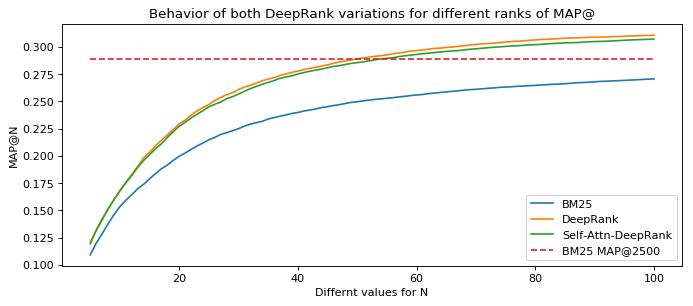

In [114]:

figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot(recall_at, bm25_y_points, '-')
plt.plot(recall_at, v2_y_points, '-')
plt.plot(recall_at, v6_y_points, '-')
plt.plot(recall_at, [0.28873476120534713]*96, '--')

plt.legend(["BM25","DeepRank","Self-Attn-DeepRank","BM25 MAP@2500"])

plt.title("Behavior of both DeepRank variations for different ranks of MAP@")
plt.xlabel("Differnt values for N")
plt.ylabel("MAP@N")

plt.show()

In [54]:
with open("bm25_result_bioasq_format.json","w") as f:
    json.dump({"questions":bm25_result_bioasq_format},f)

In [31]:
bioASQ_test_prediction = []
bioASQ_test_expectation = []

#convert to dict q_id:docs
bioASQ_deeprank_result_dict = {x["id"]:x["documents"] for x in bioASQ_deeprank_result}

for query in bioASQ_data_test:
    bioASQ_test_prediction.append(bioASQ_deeprank_result_dict[query["id"]])
    bioASQ_test_expectation.append(query["documents"])
    
f_map(predictions=bioASQ_test_prediction,expectations=bioASQ_test_expectation,at=10, use_len=True)
#bioASQ_deeprank_result[0]

0.2536610569659617

In [7]:
main_path = "/backup/bioASQ_test_set/BioASQ-TaskB-testData"
main_store_path = "/backup/bioASQ_test_set/task_B_phaseA/deep_rank_v6"

pmid_index = ph.pmid_index_mapping()
index_to_pmid = lambda x: pmid_index.inverse[x]

#BioASQ only phaseA taskb files
phaseA_taskb_filter = re.compile("phaseA_[0-9]b.*").match
phaseA_taskb_files = sorted(list(filter(phaseA_taskb_filter, os.listdir(main_path))))

import time

times_bm25 = {}
times_deeprank = {}

for test_file in phaseA_taskb_files:
    gc.collect()
    print("Open test file", test_file)
    
    with open(os.path.join(main_path, test_file),"r") as f:
        bioASQ_test_data = json.load(f)["questions"]
        bm25_start = time.time()
        bioASQ_bm25_result = bm25.predict(bioASQ_test_data, use_precomputed_score = True, top_k=2500)
        times_bm25[test_file] = time.time()-bm25_start
        
        dr_start = time.time()
        bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)
        times_deeprank[test_file] = time.time()-dr_start
        
        print(test_file,"Bm25 time:",times_bm25[test_file],"Deep rank time:",times_deeprank[test_file])
        
        with open(os.path.join(main_store_path, test_file),"w") as f:
            json.dump({"questions":bioASQ_deeprank_result},f)

        del bioASQ_test_data
        del bioASQ_bm25_result
        del bioASQ_deeprank_result


Open test file phaseA_1b_01.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Number of matching documents to query 51be1750047fa84d1d000005 8731707
Load inverted_index_bm25_1.p
Number of matching documents to query 51be1750047fa84d1d000005 9247322
Load inverted_index_bm25_2.p
Number of matching documents to query 51be1750047fa84d1d000005 9702665
Load inverted_index_bm25_3.p
Number of matching documents to query 51be1750047fa84d1d000005 9819691
Load inverted_index_bm25_4.p
Number of matching documents to query 51be1750047fa84d1d000005 9819749
Sorting the results
Start DR predict
phaseA_1b_01.json Bm25 time: 826.1890761852264 Deep rank time: 1632.0855860710144
Open test file phaseA_1b_02.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Number of matching documents to query 517843638ed59a060a000036 5594165
Load inverted_index_bm25_1.

Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Number of matching documents to query 55263a1898daae017c000001 0
Load inverted_index_bm25_1.p
Number of matching documents to query 55263a1898daae017c000001 1141540
Load inverted_index_bm25_2.p
Number of matching documents to query 55263a1898daae017c000001 1837921
Load inverted_index_bm25_3.p
Number of matching documents to query 55263a1898daae017c000001 1837921
Load inverted_index_bm25_4.p
Number of matching documents to query 55263a1898daae017c000001 1838112
Sorting the results
Start DR predict
phaseA_3b_04.json Bm25 time: 777.3328576087952 Deep rank time: 1551.3845670223236
Open test file phaseA_3b_05.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Number of matching documents to query 554a0cadf35db7552600000f 4209147
Load inverted_index_bm25_1.p
Number of matching documents to query 554a0cadf35db7552600000f 6737897
Load i

Load inverted_index_bm25_0.p
Number of matching documents to query 589a246f78275d0c4a000034 8294712
Load inverted_index_bm25_1.p
Number of matching documents to query 589a246f78275d0c4a000034 8294712
Load inverted_index_bm25_2.p
Number of matching documents to query 589a246f78275d0c4a000034 8474004
Load inverted_index_bm25_3.p
Number of matching documents to query 589a246f78275d0c4a000034 8560040
Load inverted_index_bm25_4.p
Number of matching documents to query 589a246f78275d0c4a000034 8560051
Sorting the results
Start DR predict
phaseA_5b_05.json Bm25 time: 744.8465456962585 Deep rank time: 1510.5974576473236


In [4]:
##TASK 7B


main_path = "/backup/bioASQ_test_set/BioASQ-TaskB-testData"
main_store_path = "/backup/bioASQ_test_set/task_B_phaseA/bm25"

pmid_index = ph.pmid_index_mapping()
index_to_pmid = lambda x: pmid_index.inverse[x]

#BioASQ only phaseA taskb files
phaseA_taskb_files = ["BioASQ-task7bPhaseA-testset1.json",
                      "BioASQ-task7bPhaseA-testset2.json",
                      "BioASQ-task7bPhaseA-testset3.json",
                      "BioASQ-task7bPhaseA-testset4.json",
                      "BioASQ-task7bPhaseA-testset5.json"]

import time

times_bm25 = {}
times_deeprank = {}

for test_file in phaseA_taskb_files[:1]:
    gc.collect()
    print("Open test file", test_file)
    
    with open(os.path.join(main_path, test_file),"r") as f:
        bioASQ_test_data = json.load(f)["questions"]
        bm25_start = time.time()
        bioASQ_bm25_result = bm25.predict(bioASQ_test_data, use_precomputed_score = True, top_k=2500)
        times_bm25[test_file] = time.time()-bm25_start
        
        bioASQ_deeprank_result = []
        for _id,q in bioASQ_bm25_result.items(): 
            documents = list(map(lambda x:"http://www.ncbi.nlm.nih.gov/pubmed/"+index_to_pmid(x[0]),q["documents"]))[:10]
            bioASQ_deeprank_result.append({"id":_id,"body":q["body"],"documents":documents})
            
        dr_start = time.time()
        bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)
        times_deeprank[test_file] = time.time()-dr_start
        
        print(test_file,"Bm25 time:",times_bm25[test_file],"Deep rank time:",times_deeprank[test_file])
        
        with open(os.path.join(main_store_path, test_file),"w") as f:
            json.dump({"questions":bioASQ_deeprank_result},f)

        del bioASQ_test_data
        del bioASQ_bm25_result
        del bioASQ_deeprank_result


Load /backup/saved_models/pmid_index_mapping.p
Open test file BioASQ-task7bPhaseA-testset1.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Time load index 64.23182010650635
Number of matching documents to query 5c58b26386df2b9174000011 0
Load inverted_index_bm25_1.p
Time load index 70.73139905929565
Number of matching documents to query 5c58b26386df2b9174000011 3753827
Load inverted_index_bm25_2.p
Time load index 64.78145623207092
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_3.p
Time load index 52.45214223861694
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_4.p
Time load index 49.29420828819275
Number of matching documents to query 5c58b26386df2b9174000011 4174451
Sorting the results
Time sort results 184.52621817588806
Start DR predict
Prediction avg time 9.682724449634552 Sort avg time 0.001482234001159667

In [11]:
## # TEST N=1000


times_bm25 = {}
times_deeprank = {}

for test_file in phaseA_taskb_files[:1]:
    gc.collect()
    print("Open test file", test_file)
    
    with open(os.path.join(main_path, test_file),"r") as f:
        bioASQ_test_data = json.load(f)["questions"]
        bm25_start = time.time()
        bioASQ_bm25_result = bm25.predict(bioASQ_test_data, use_precomputed_score = True, top_k=1000)
        times_bm25[test_file] = time.time()-bm25_start
        
        bioASQ_deeprank_result = []
        for _id,q in bioASQ_bm25_result.items(): 
            documents = list(map(lambda x:"http://www.ncbi.nlm.nih.gov/pubmed/"+index_to_pmid(x[0]),q["documents"]))[:10]
            bioASQ_deeprank_result.append({"id":_id,"body":q["body"],"documents":documents})
            
        dr_start = time.time()
        bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)
        times_deeprank[test_file] = time.time()-dr_start
        
        print(test_file,"Bm25 time:",times_bm25[test_file],"Deep rank time:",times_deeprank[test_file])
        
        with open(os.path.join(main_store_path, test_file),"w") as f:
            json.dump({"questions":bioASQ_deeprank_result},f)

        del bioASQ_test_data
        del bioASQ_bm25_result
        del bioASQ_deeprank_result

Open test file BioASQ-task7bPhaseA-testset1.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Time load index 58.60803747177124
Number of matching documents to query 5c58b26386df2b9174000011 0
Load inverted_index_bm25_1.p
Time load index 64.51105737686157
Number of matching documents to query 5c58b26386df2b9174000011 3753827
Load inverted_index_bm25_2.p
Time load index 61.43285775184631
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_3.p
Time load index 53.54809379577637
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_4.p
Time load index 48.91657590866089
Number of matching documents to query 5c58b26386df2b9174000011 4174451
Sorting the results
Time sort results 181.76991415023804
Start DR predict
Prediction avg time 3.9337981295585633 Sort avg time 0.0005385231971740723
BioASQ-task7bPhaseA-testset1.json Bm25 time:

In [10]:
## # TEST N=2500


times_bm25 = {}
times_deeprank = {}

for test_file in phaseA_taskb_files[:1]:
    gc.collect()
    print("Open test file", test_file)
    
    with open(os.path.join(main_path, test_file),"r") as f:
        bioASQ_test_data = json.load(f)["questions"]
        bm25_start = time.time()
        bioASQ_bm25_result = bm25.predict(bioASQ_test_data, use_precomputed_score = True, top_k=2500)
        times_bm25[test_file] = time.time()-bm25_start
        
        bioASQ_deeprank_result = []
        for _id,q in bioASQ_bm25_result.items(): 
            documents = list(map(lambda x:"http://www.ncbi.nlm.nih.gov/pubmed/"+index_to_pmid(x[0]),q["documents"]))[:10]
            bioASQ_deeprank_result.append({"id":_id,"body":q["body"],"documents":documents})
            
        dr_start = time.time()
        bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)
        times_deeprank[test_file] = time.time()-dr_start
        
        print(test_file,"Bm25 time:",times_bm25[test_file],"Deep rank time:",times_deeprank[test_file])
        
        with open(os.path.join(main_store_path, test_file),"w") as f:
            json.dump({"questions":bioASQ_deeprank_result},f)

        del bioASQ_test_data
        del bioASQ_bm25_result
        del bioASQ_deeprank_result

Open test file BioASQ-task7bPhaseA-testset1.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Time load index 59.997483253479004
Number of matching documents to query 5c58b26386df2b9174000011 0
Load inverted_index_bm25_1.p
Time load index 63.96471166610718
Number of matching documents to query 5c58b26386df2b9174000011 3753827
Load inverted_index_bm25_2.p
Time load index 61.531686782836914
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_3.p
Time load index 53.90048575401306
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_4.p
Time load index 50.18094229698181
Number of matching documents to query 5c58b26386df2b9174000011 4174451
Sorting the results
Time sort results 185.24572730064392
Start DR predict
Prediction avg time 9.52492035150528 Sort avg time 0.001485128402709961
BioASQ-task7bPhaseA-testset1.json Bm25 time: 

In [6]:
## # TEST N=1000
main_path = "/backup/bioASQ_test_set/BioASQ-TaskB-testData"
main_store_path = "/backup/bioASQ_test_set/task_B_phaseA/bm25"

pmid_index = ph.pmid_index_mapping()
index_to_pmid = lambda x: pmid_index.inverse[x]
import time 
#BioASQ only phaseA taskb files
phaseA_taskb_files = ["BioASQ-task7bPhaseA-testset1.json",
                      "BioASQ-task7bPhaseA-testset2.json",
                      "BioASQ-task7bPhaseA-testset3.json",
                      "BioASQ-task7bPhaseA-testset4.json",
                      "BioASQ-task7bPhaseA-testset5.json"]

times_bm25 = {}
times_deeprank = {}

for test_file in phaseA_taskb_files[:1]:
    gc.collect()
    print("Open test file", test_file)
    
    with open(os.path.join(main_path, test_file),"r") as f:
        bioASQ_test_data = json.load(f)["questions"]
        bm25_start = time.time()
        bioASQ_bm25_result = bm25.predict(bioASQ_test_data, use_precomputed_score = True, top_k=1000)
        times_bm25[test_file] = time.time()-bm25_start
        
        bioASQ_deeprank_result = []
        for _id,q in bioASQ_bm25_result.items(): 
            documents = list(map(lambda x:"http://www.ncbi.nlm.nih.gov/pubmed/"+index_to_pmid(x[0]),q["documents"]))[:10]
            bioASQ_deeprank_result.append({"id":_id,"body":q["body"],"documents":documents})
            
        dr_start = time.time()
        bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)
        times_deeprank[test_file] = time.time()-dr_start
        
        print(test_file,"Bm25 time:",times_bm25[test_file],"Deep rank time:",times_deeprank[test_file])
        
        with open(os.path.join(main_store_path, test_file),"w") as f:
            json.dump({"questions":bioASQ_deeprank_result},f)

        del bioASQ_test_data
        del bioASQ_bm25_result
        del bioASQ_deeprank_result

Load /backup/saved_models/pmid_index_mapping.p
Open test file BioASQ-task7bPhaseA-testset1.json
Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Time load index 59.752748012542725
Number of matching documents to query 5c58b26386df2b9174000011 0
Load inverted_index_bm25_1.p
Time load index 65.97746562957764
Number of matching documents to query 5c58b26386df2b9174000011 3753827
Load inverted_index_bm25_2.p
Time load index 63.64831066131592
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_3.p
Time load index 53.43592071533203
Number of matching documents to query 5c58b26386df2b9174000011 4174427
Load inverted_index_bm25_4.p
Time load index 49.72488617897034
Number of matching documents to query 5c58b26386df2b9174000011 4174451
Sorting the results
Time sort results 178.61085629463196
Start DR predict
Prediction avg time 1.930857002735138 Sort avg time 0.00054939746856689

In [4]:
main_path = "/backup/bioASQ_test_set/BioASQ-TaskB-testData"


#pmid_index = ph.pmid_index_mapping()
#index_to_pmid = lambda x: pmid_index.inverse[x]


with open(os.path.join(main_path, "phaseA_5b_01.json"),"r") as f:
    bioASQ_test_data = json.load(f)["questions"]
    bioASQ_bm25_result = bm25.predict(bioASQ_test_data[:10], use_precomputed_score = True, top_k=2500)

    bioASQ_deeprank_result = deeprank.predict(bioASQ_bm25_result, map_f = index_to_pmid, collection = articles)

#    with open(os.path.join(main_store_path, "phaseA_5b_01_v6.json"),"w") as f:
#        json.dump({"questions":bioASQ_deeprank_result},f)

Load bllip_stem_full_tokens_tokenizer.p
Precomputed score: Enable
Using map function: Disable
Load inverted_index_bm25_0.p
Time load index 66.95635485649109
Number of matching documents to query 58a9bbe81978bbde22000007 4051524
Load inverted_index_bm25_1.p
Time load index 70.43462443351746
Number of matching documents to query 58a9bbe81978bbde22000007 4051524
Load inverted_index_bm25_2.p
Time load index 65.62473607063293
Number of matching documents to query 58a9bbe81978bbde22000007 4582607
Load inverted_index_bm25_3.p
Time load index 54.23331594467163
Number of matching documents to query 58a9bbe81978bbde22000007 4582607
Load inverted_index_bm25_4.p
Time load index 51.06432485580444
Number of matching documents to query 58a9bbe81978bbde22000007 4582628
Sorting the results
Time sort results 23.129615783691406


NameError: name 'index_to_pmid' is not defined

In [362]:

#document = [q_data["documents"][1]]
#X = deeprankV6._prepare_data(query,document_index,articles)

#print(query, document)

#articles[document[0][0]]

What kind of analyses are performed with the software tool "unipept"


In [40]:
from tensorflow.keras import backend as K
import numpy as np

from IPython.display import HTML as html_print


#deeprankV6 = deeprank

#snippet_attention_tensor = deeprankV6.document_score_model.layers[11].attention_weights
#q_term_attention_tensor = deeprankV6.document_score_model.layers[14].attention_weights

#get_snippet_attn = K.function(deeprankV6.document_score_model.input, snippet_attention_tensor)
#get_term_attn = K.function(deeprankV6.document_score_model.input, [q_term_attention_tensor])


def red_percentage_print(s, percentage):
    rescale = 100-int(percentage*100)
    return "<text style=background-color:hsl(0,100%,{}%);>{}</text>".format(rescale, s)

def blue_percentage_print(s, percentage):
    rescale = 100-int(percentage*100)
    return "<text style=background-color:hsl(220,100%,{}%);>{}</text>".format(rescale, s)

def highlight_snippets(query, document_index,articles, TOP_SNIPPETS = 5, TOP_QUERY = 5):
    X = deeprankV6._prepare_data(query,document_index,articles)
    
    snippet_attn = np.squeeze(np.array(get_snippet_attn(X)))
    term_attn = np.expand_dims(np.squeeze(np.array(get_term_attn(X))),axis=-1)
    
    comb_W = (snippet_attn*term_attn)
    comb_W_1d =comb_W.ravel()
    print(comb_W_1d)
    #top 5 snippet index
    snippets_indexs = comb_W_1d.argsort()[-TOP_SNIPPETS:][::-1]
    
    #snippets_ravel_attention_normalize = comb_W_1d[snippets_indexs]/sum(comb_W_1d[snippets_indexs])
    snippets_ravel_attention =  comb_W_1d[snippets_indexs]/sum(comb_W_1d[snippets_indexs])
    #snippets_ravel_attention = snippets_ravel_attention/sum(snippets_ravel_attention)
    #print("Snippet attention non-normalize", snippets_ravel_attention)
    print("Snippet attention normalize", snippets_ravel_attention)
    
    query_list_string = [deeprankV6.tokenizer.index_word[x] for x in X[0][0] if x != 0]
    
    term_attn_ravel = term_attn.ravel()
    TOP_QUERY = min(len(query_list_string),TOP_QUERY)
    top_5_q_terms = term_attn_ravel.argsort()[-TOP_QUERY:][::-1]
    highlight_terms = term_attn_ravel[top_5_q_terms]/sum(term_attn_ravel[top_5_q_terms])

    

    for count,index in enumerate(top_5_q_terms):
        if index>=len(query_list_string):
            continue
            
        query_list_string[index] = red_percentage_print(query_list_string[index],highlight_terms[count])

    doc_tokens = deeprankV6.tokenizer.texts_to_sequences([articles[document_index[0][0]]])[0]

    doc_list_string = [deeprankV6.tokenizer.index_word[x]+" " for x in doc_tokens if x != 0]

    snippet_position_ravel = X[2][0].ravel()

    for count,index in enumerate(snippets_indexs):

        index = snippet_position_ravel[index]
        if index==-1:
            continue
        low_index = max(0,index-7)
        high_index = max(0,index+7)

        doc_list_string[low_index:high_index] = list(map(lambda x:blue_percentage_print(x,snippets_ravel_attention[count]),doc_list_string[low_index:high_index]))


    return query_list_string, doc_list_string
    

    
#get_snippet_rep = K.function(deeprank.document_score_model.input, [deeprank.document_score_model.layers[11].output])
#print(f([x])[0])  # your activation tensor

In [73]:
#VISUALIZATION

#convert bioasq data to dict
bioasq_validation_dict = {x["id"]:{"documents":x["documents"],"body":x["body"]} for x in bioASQ_data_test}
bioASQ_deeprankV6_result = [{"id":k,"documents":v} for k,v in deep_rank_v6_result_dict.items()]



r_to_analysis = bioASQ_deeprankV6_result[424]
q_data = bioasq_validation_dict[r_to_analysis["id"]]
document_index = [(pmid_index_mapping[(r_to_analysis["documents"][3].split("/")[-1])],0)]
query = q_data["body"]

print(q_data["documents"])
print(list(map(lambda x:x.split("/")[-1],r_to_analysis["documents"][:10])))

query_list_string, doc_list_string = highlight_snippets(query, document_index, articles, TOP_QUERY=13, TOP_SNIPPETS=10)

print("QUERY:",query)
html_print("<h3>Tokenized query</h3><p>"+" ".join(query_list_string)+"</p><h3>Tokenized document</h3><p>"+"".join(doc_list_string)+"</p>")

['22906540', '24097866', '25120190', '21062983', '20048334', '25627551', '24409321', '26332545', '23545855', '25441685', '26332546']
['25627551', '22906540', '25920748', '25120190', '21062983', '26498179', '20824134', '26183089', '28270692', '19908230']
[0.0169331  0.0169331  0.0169331  0.0169331  0.0169331  0.02220209
 0.04258719 0.0027066  0.0027066  0.0027066  0.1358276  0.18367065
 0.15451522 0.01167307 0.01167307 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132
 0.00690132 0.00690132 0.00690132 0.00690132 0.00690132]
Snippet attention n

In [482]:
import numpy as np

snippet_attn = np.squeeze(np.array(get_snippet_attn(X)))
term_attn = np.expand_dims(np.squeeze(np.array(get_term_attn(X))),axis=-1)



#print(snippet_attn.shape, term_attn.shape)

#print(snippet_attn)
#print(term_attn)

In [364]:
comb_W = (snippet_attn*term_attn)
comb_W_1d =comb_W.ravel()
print(comb_W_1d)
#top 5 snippet index
snippets_indexs = comb_W_1d.argsort()[-5:][::-1]
print(snippets_indexs)
print(comb_W_1d[snippets_indexs])

[0.01490178 0.01490178 0.01490178 0.01490178 0.01490178 0.01654428
 0.01654428 0.01654428 0.01654428 0.01654428 0.00865611 0.00865611
 0.00865611 0.00865611 0.00865611 0.126877   0.01038423 0.01038423
 0.01038423 0.01038423 0.01044998 0.01044998 0.01044998 0.01044998
 0.01044998 0.08589135 0.08489069 0.09232812 0.00728842 0.00728842
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395
 0.00860395 0.00860395 0.00860395 0.00860395 0.00860395]
[15 27 25 26  8]
[0.126877   0.09232812 0.08589135 0.08489069 0.01654428]


In [365]:
snippets_ravel_attention = comb_W_1d[snippets_indexs]/sum(comb_W_1d[snippets_indexs])
snippets_ravel_attention = comb_W_1d[snippets_indexs]
#print(snippets_ravel_attention)

In [366]:
indexs2d = list(map(lambda x: (x//5,x%5),snippets_indexs))
docs = deeprankV6.tokenizer.sequences_to_texts(map(lambda x:X[1][0][x[0]][x[1]], indexs2d))
print(indexs2d)
docs


[(3, 0), (5, 2), (5, 0), (5, 1), (1, 3)]


['loaded into persistent local browser storage the software computes and visualizes pan and core',
 'the lowest common ancestor algorithm implemented in unipept and modern web technologies that facilitate',
 'targeted metaproteomics the unique peptide finder http unipept ugent be peptidefinder is an interactive',
 'fast since they are underpinned by the unipept database the lowest common ancestor algorithm',
 '']

In [357]:
deeprankV6.tokenizer.sequences_to_texts([X[0][0]])

['kind analyses performed software tool unipept']

In [358]:
articles[document_index[0][0]]

'High-throughput metaproteomics data analysis with Unipept: A tutorial. In recent years, shotgun metaproteomics has established itself as an important tool to study the composition of complex ecosystems and microbial communities. Two key steps in metaproteomics data analysis are the inference of proteins from the identified peptides, and the determination of the taxonomic origin and function of these proteins. This tutorial therefore introduces the Unipept command line interface (http://unipept.ugent.be/clidocs) as a platform-independent tool for such metaproteomics data analyses. First, a detailed overview is given of the available Unipept commands and their functions. Next, the power of the Unipept command line interface is illustrated using two case studies that analyze a single tryptic peptide, and a set of peptides retrieved from a shotgun metaproteomics experiment, respectively. Finally, the analysis results obtained using these command line tools are compared with the interactiv

In [180]:
"loaded into persistent local browser storage the software computes and visualizes pan and core"

False

In [306]:

def red_percentage_print(s, percentage):
    rescale = 100-int(percentage*100)
    return "<text style=background-color:hsl(0,100%,{}%);>{}</text>".format(rescale, s)

def blue_percentage_print(s, percentage):
    rescale = 100-int(percentage*100)
    return "<text style=background-color:hsl(220,100%,{}%);>{}</text>".format(rescale, s)

left, word, right = 'foo' , 'abc' , 'bar'
html_print("hello "+red_percentage_print(left,0.31)+" "+red_percentage_print(word,0.22))

In [367]:



term_attn_ravel = term_attn.ravel()
top_5_q_terms = term_attn_ravel.argsort()[-5:][::-1]
highlight_terms = term_attn_ravel[top_5_q_terms]/sum(term_attn_ravel[top_5_q_terms])



In [368]:
query_list_string = [deeprankV6.tokenizer.index_word[x] for x in X[0][0] if x != 0]

for count,index in enumerate(top_5_q_terms):
    query_list_string[index] = red_percentage_print(query_list_string[index],highlight_terms[count])
    
html_print(" ".join(query_list_string))

In [369]:
doc_tokens = deeprankV6.tokenizer.texts_to_sequences([articles[document_index[0][0]]])[0]

doc_list_string = [deeprankV6.tokenizer.index_word[x]+" " for x in doc_tokens if x != 0]

snippet_position_ravel = X[2][0].ravel()

for count,index in enumerate(snippets_indexs):
    
    index = snippet_position_ravel[index]
    
    low_index = max(0,index-7)
    high_index = max(0,index+7)
    
    doc_list_string[low_index:high_index] = list(map(lambda x:blue_percentage_print(x,snippets_ravel_attention[count]),doc_list_string[low_index:high_index]))


html_print("<h3>Tokenized query</h3><p>"+" ".join(query_list_string)+"</p><h3>Tokenized document</h3><p>"+"".join(doc_list_string)+"</p>")



In [311]:
html_print("<h3>Query</h3><p>"+query+"</p><h3>Document</h3><p>"+articles[document_index[0][0]]+"</p>")
